# Data Reduction and Transformation


In [85]:
import transformation_utils as utils
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler

In [86]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [87]:
df = pd.read_csv("../data/integrated.csv")
target = "playoff"

## Eliminating Redundant Features


In [88]:
df.drop(
    [
        "round",
        "series",
        "tmIDWinner",
        "tmIDLoser",
        "W_series",
        "L_series",
        "franchID",
        "name",
        "bioID",
        "coachID",
    ],
    axis=1,
    inplace=True,
)

## Feature Engineering


In [89]:
new_df = pd.DataFrame()
for year in df["year"].unique():
    for team in df["tmID"].unique():
        small_df = df[(df["tmID"] == team) & (df["year"] == year)]
        if small_df.empty:
            continue

        d = pd.DataFrame([small_df.iloc[0]])
        d.fillna(0, inplace=True)
        d["award_player"] = small_df["award_player"].count()
        d["award_coach"] = d["award_coach"].apply(lambda i: 1 if i != 0 else 0)
        d["CBE_Sum"] = small_df["CBE_Sum"].mean()
        d["height"] = small_df["height"].mean()
        d["weight"] = small_df["weight"].mean()
        d["playersAge"] = (2000 + df["year"]) - utils.get_overall_age(
            small_df["birthDate"]
        )
        d.drop("playerID", axis=1, inplace=True)
        d.drop("birthDate", axis=1, inplace=True)

        new_df = pd.concat([new_df, d])

df = new_df.sort_values(by=["year", "tmID"])

In [90]:
mapping = {"L": 1, "W": 1, "N": 0}

df["semis"] = df["semis"].map(mapping)
df["finals"] = df["finals"].map(mapping)
df["firstRound"] = df["firstRound"].map(mapping)

df["roundsPlayed"] = df["semis"] + df["finals"] + df["firstRound"]
df.drop(["semis", "finals", "firstRound"], axis=1, inplace=True)

## Manual Feature Selection


In [91]:
utils.print_columns(df)
df.drop(
    [
        "attend",
        "arena",
        "awayL",
        "confL",
        "homeL",
        "d_oreb",
        "d_dreb",
        "o_oreb",
        "o_dreb",
        "L_team_post",
        "lost_team",
    ],
    axis=1,
    inplace=True,
)

[ year, tmID, W_team_post, L_team_post, confID, rank, playoff, o_fgm, o_fga, o_ftm, o_fta, o_3pm, o_3pa, o_oreb, o_dreb, o_reb, o_asts, o_pf, o_stl, o_to, o_blk, o_pts, d_fgm, d_fga, d_ftm, d_fta, d_3pm, d_3pa, d_oreb, d_dreb, d_reb, d_asts, d_pf, d_stl, d_to, d_blk, d_pts, won_team, lost_team, GP, homeW, homeL, awayW, awayL, confW, confL, min, attend, arena, stint, won_coach, lost_coach, post_wins, post_losses, CBE_Sum, height, weight, award_player, award_coach, playersAge, roundsPlayed ]


In [92]:
# Assuming your DataFrame is named 'df'
# Define weights for each statistic
w1, w2, w3, w4 = 1, 0.8, 0.5, 0.7  # Adjust these weights based on your preferences

# Calculate ATR for each row
df["ATR"] = (
    (w1 * (df["o_pts"]) - df["d_pts"])
    + (w2 * (df["o_reb"] - df["d_reb"]))
    + (w3 * (df["o_asts"] - df["d_asts"]))
    + (w4 * (df["o_fgm"] - df["d_fgm"]))
)

df.drop(
    ["o_pts", "o_reb", "o_asts", "o_fgm", "d_pts", "d_reb", "d_asts", "d_fgm"],
    axis=1,
    inplace=True,
)

## Feature Encoding


In [93]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])
df["confID"] = le.fit_transform(df["confID"])

key_cols = ["confID", "year", "playoff", "tmID"]
numerical_cols = [col for col in df.columns if col not in key_cols]

## Feature Scaling


In [94]:
scaler = RobustScaler()
normalizer = MinMaxScaler()

df[numerical_cols] = scaler.fit_transform(df.drop(key_cols, axis=1))
df[numerical_cols] = normalizer.fit_transform(df.drop(key_cols, axis=1))
df.head()

,year,tmID,W_team_post,confID,rank,playoff,o_fga,o_ftm,o_fta,o_3pm,...,post_wins,post_losses,CBE_Sum,height,weight,award_player,award_coach,playersAge,roundsPlayed,ATR
123,2,CHA,0.000000,0,1.000000,1,0.218792,0.292537,0.261501,0.312217,...,0.000000,0.0,0.316584,0.262097,0.330043,0.000000,0.0,0.440079,0.000000,0.255930
210,2,CLE,0.428571,0,0.142857,1,0.118121,0.277612,0.244552,0.357466,...,0.428571,0.6,0.452861,0.395161,0.625732,0.000000,0.0,0.261297,0.666667,0.651684
376,2,DET,0.000000,0,0.571429,0,0.322148,0.555224,0.556901,0.063348,...,0.000000,0.0,0.147339,0.383065,0.337606,0.000000,0.0,0.385069,0.000000,0.450269
206,2,HOU,0.857143,1,0.142857,1,0.206711,0.561194,0.399516,0.497738,...,0.857143,0.0,0.110306,0.410557,0.476134,0.333333,0.0,0.706376,1.000000,1.000000
262,2,IND,0.000000,0,0.857143,0,0.131544,0.283582,0.242131,0.592760,...,0.000000,0.0,0.322328,0.415633,0.436789,0.000000,0.0,0.329001,0.000000,0.431374


## Grid Search for SelectKBest and PCA


In [95]:
random_state = 42

Simple version of Grid Search for SelectKBest and PCA where the classifier is already defined. If the user want, it can leave the following codes of block commented. These may only be activated to print out the optimal values for SelectKBest and PCA, to change them afterwards. If you've already calculated which are the optimal values, no need to run these again.


In [96]:
# from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(batch_size=8, max_iter=10000, random_state=random_state)
# results = utils.grid_search_features(df, key_cols, target, clf, 10)
# utils.display_num_features_results(results)

In this version, we run the Grid Search for several classifiers and compare the results.


In [97]:
# classifiers = [
#     ("DTC", DecisionTreeClassifier(random_state=random_state)),
#     ("MLP", MLPClassifier(batch_size=8, max_iter=10000, random_state=random_state)),
#     ("SVM", SVC(probability=True, random_state=random_state)),
#     ("RFC", RandomForestClassifier(random_state=random_state)),
#     ("KNN", KNeighborsClassifier(n_neighbors=5, weights="distance")),
#     ("Bagging", BaggingClassifier(random_state=random_state)),
#     ("AdaBoost", AdaBoostClassifier(random_state=random_state)),
#     ("GradientBoosting", GradientBoostingClassifier(random_state=random_state)),
#     ("ExtraTrees", ExtraTreesClassifier(random_state=random_state)),
#     ("LogisticRegression", LogisticRegression(random_state=random_state)),
#     ("NB", GaussianNB()),
# ]
# results = []
# for classifier in classifiers:
#     grid = utils.grid_search_features(df, key_cols, target, classifier[1], 10)
#     results.append((classifier[0], grid[0]))
# print(results)

## Feature Selection


In [98]:
n_features = 16
n_components = 6

df_copy = df.copy(
    deep=True
)  # Copy of the dataframe before we do feature selection and aggregation

In [99]:
initial = df.columns
df = utils.select_features(df, target, key_cols, n_features)

print("Removed: ", set(initial) - set(df.columns))

Removed:  {'o_ftm', 'd_3pa', 'o_stl', 'o_fga', 'GP', 'o_fta', 'min', 'o_3pa', 'd_to', 'o_to', 'd_blk', 'height', 'weight', 'd_fta', 'd_fga', 'd_ftm', 'd_pf', 'award_coach', 'o_pf', 'd_stl', 'o_blk', 'd_3pm', 'o_3pm'}


## Feature Aggregation


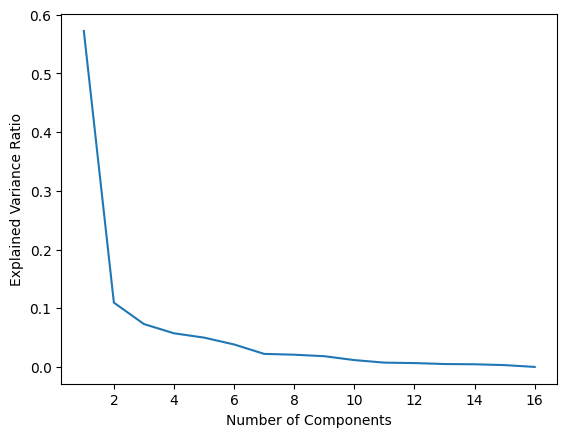

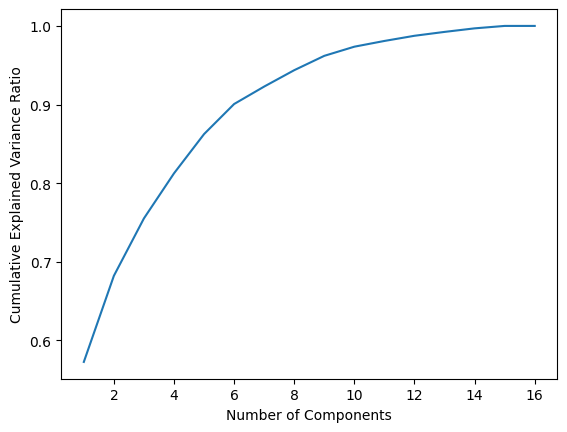

In [100]:
utils.plot_pca(df.drop(key_cols, axis=1))

In [101]:
old_df = df.copy()
df = utils.feature_aggregation_pca(df, n_components, key_cols)
utils.print_columns(df)

[ PC1, PC2, PC3, PC4, PC5, PC6, confID, year, playoff, tmID ]


## Checking for Correlation


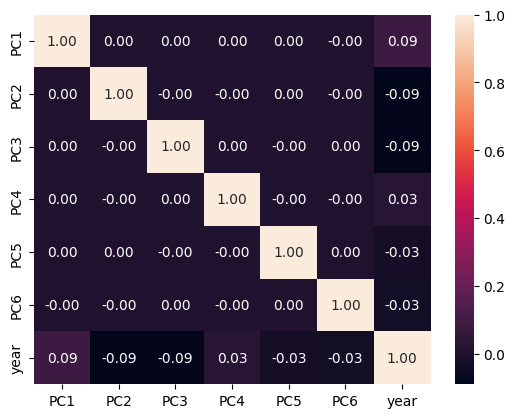

<Figure size 14400x14400 with 0 Axes>

In [102]:
corr_excluded_cols = key_cols[:]
corr_excluded_cols.remove("year")
utils.plot_correlation(df.drop(corr_excluded_cols, axis=1))

## Checking for null values


In [103]:
print("Number of null values: ", df.isnull().sum().sum())

Number of null values:  0


## Creating new dataframes for each model


These datasets that are being created in the following code block are only being used in the case of Manual Ensemble usage. These values come from the result of grid classification to understand which are the optimal values for SelectKBest and PCA.

In [104]:
import os, shutil, copy

# (Model, (n_features, n_components, accuracy, f1_score, auc))
models = [
    ("DTC", (35, 7, 84.61999999999999, 87.5, 80.0)),
    ("MLP", (14, 4, 100.0, 100.0, 100.0)),
    ("SVM", (20, 9, 69.23, 75.0, 77.5)),
    ("RFC", (14, 11, 84.61999999999999, 87.5, 80.0)),
    ("KNN", (29, 13, 69.23, 75.0, 82.5)),
    ("Bagging", (17, 13, 84.61999999999999, 87.5, 78.75)),
    ("AdaBoost", (12, 9, 100.0, 100.0, 100.0)),
    ("GradientBoosting", (20, 6, 100.0, 100.0, 95.0)),
    ("ExtraTrees", (11, 4, 84.61999999999999, 87.5, 87.5)),
    ("LogisticRegression", (12, 4, 84.61999999999999, 87.5, 90.0)),
    ("NB", (17, 7, 100.0, 100.0, 100.0)),
]

if os.path.exists("../data/transformed"):
    shutil.rmtree("../data/transformed")
os.mkdir("../data/transformed")
for model in models:
    df_copy1 = df_copy.copy(deep=True)
    df_copy1 = utils.select_features(df_copy1, target, key_cols, model[1][0])
    df_copy1 = utils.feature_aggregation_pca(df_copy1, model[1][1], key_cols)
    df_copy1.to_csv(f"../data/transformed/{model[0]}.csv", index=False)

# Saving the data


In [105]:
df.to_csv("../data/transformed.csv", index=False)